In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from classes.DQNagentClass import DQNAgent, DDQNAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON, readJSON

In [4]:
#CREATING THE ENVIRONMENT
shape = "5x5"             # "5x5" or "14x14"
env = createNNEnv(shape)

Loading models...
Models loaded


In [19]:
#Hyperparameters
train = True            # train or test
show_stats = True       # show stats
export_to_JSON = True   # write JSON file
render = True           # render the results after training

NUM_DQN_AGENTS = 3     # number of DQN agents
NUM_DDQN_AGENTS = 0     # number of DDQN agents

SEED = 0                # random seed. 0 for all
NUM_NEURONS_FC1 = 128   # number of neurons for the first fully connected layer
NUM_NEURONS_FC2 = 128   # number of neurons for the second fully connected layer

EPISODES_PER_AGENT = 1000
MAX_STEPS_PER_EPISODE = 50

EPS_START = 1.0         # epsilon start value
EPS_END = 0.01          # epsilon end value
EPS_DECAY = 0.996       # epsilon decay rate
#EPS_DECAY = EPS_START/(EPISODES_PER_AGENT/2)

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network



In [20]:
#CREATING THE AGENTS
agents_arr = []         # array of agents
scores_arr = []         # array of scores of the episodes
durations_arr = []      # array of durations of the episodes
starting_positions = [] # array of starting positions for each agent

for i in range(NUM_DQN_AGENTS):
    path_to_save = "../data/agent_models/pytorch/DQNagent"+str(i+1)+".pt" # path to save the model
    agent = DQNAgent(path_to_save, env, SEED, NUM_NEURONS_FC1, NUM_NEURONS_FC2, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, EPS_START, EPS_END, EPS_DECAY, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
    agents_arr.append(agent) # append the agent to the array

for i in range(NUM_DDQN_AGENTS):
    path_to_save = "../data/agent_models/pytorch/DDQNagent"+str(i+1)+".pt" # path to save the model
    agent = DDQNAgent(path_to_save, env, SEED, NUM_NEURONS_FC1, NUM_NEURONS_FC2, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, EPS_START, EPS_END, EPS_DECAY, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
    agents_arr.append(agent) # append the agent to the array

In [21]:
#TRAINING
if train:
    print("Starting training of", NUM_DQN_AGENTS, "DQN agents and", NUM_DDQN_AGENTS, "DDQN agents")
    
    for agent in agents_arr:
        env.unwrapped.randomize_start_pos()     # randomize the starting position of the agent in the grid environment
        if agents_arr.index(agent) < NUM_DQN_AGENTS:
            print("DQN Agent", agents_arr.index(agent)+1,"/",NUM_DQN_AGENTS)    # if the agent is a DQN agent
        else:
            print("DDQN Agent", agents_arr.index(agent)+1-NUM_DQN_AGENTS,"/",NUM_DDQN_AGENTS)  # if the agent is a DDQN agent 

        scores, durations = agent.train()
        scores_arr.append(scores)
        durations_arr.append(durations)
        starting_positions.append(env.unwrapped.start_pos)

Starting training of 3 DQN agents and 0 DDQN agents
DQN Agent 1 / 3


100%|██████████| 1000/1000 [00:16<00:00, 61.48it/s]


DQN Agent 2 / 3


100%|██████████| 1000/1000 [00:17<00:00, 58.69it/s]


DQN Agent 3 / 3


100%|██████████| 1000/1000 [00:17<00:00, 58.39it/s]


Agent 1 steps stats: 	Average 13.0 	Std dev 13.34 	Median 7.0 	Best 6
Agent 2 steps stats: 	Average 12.99 	Std dev 13.33 	Median 7.0 	Best 6
Agent 3 steps stats: 	Average 13.06 	Std dev 13.8 	Median 6.0 	Best 6


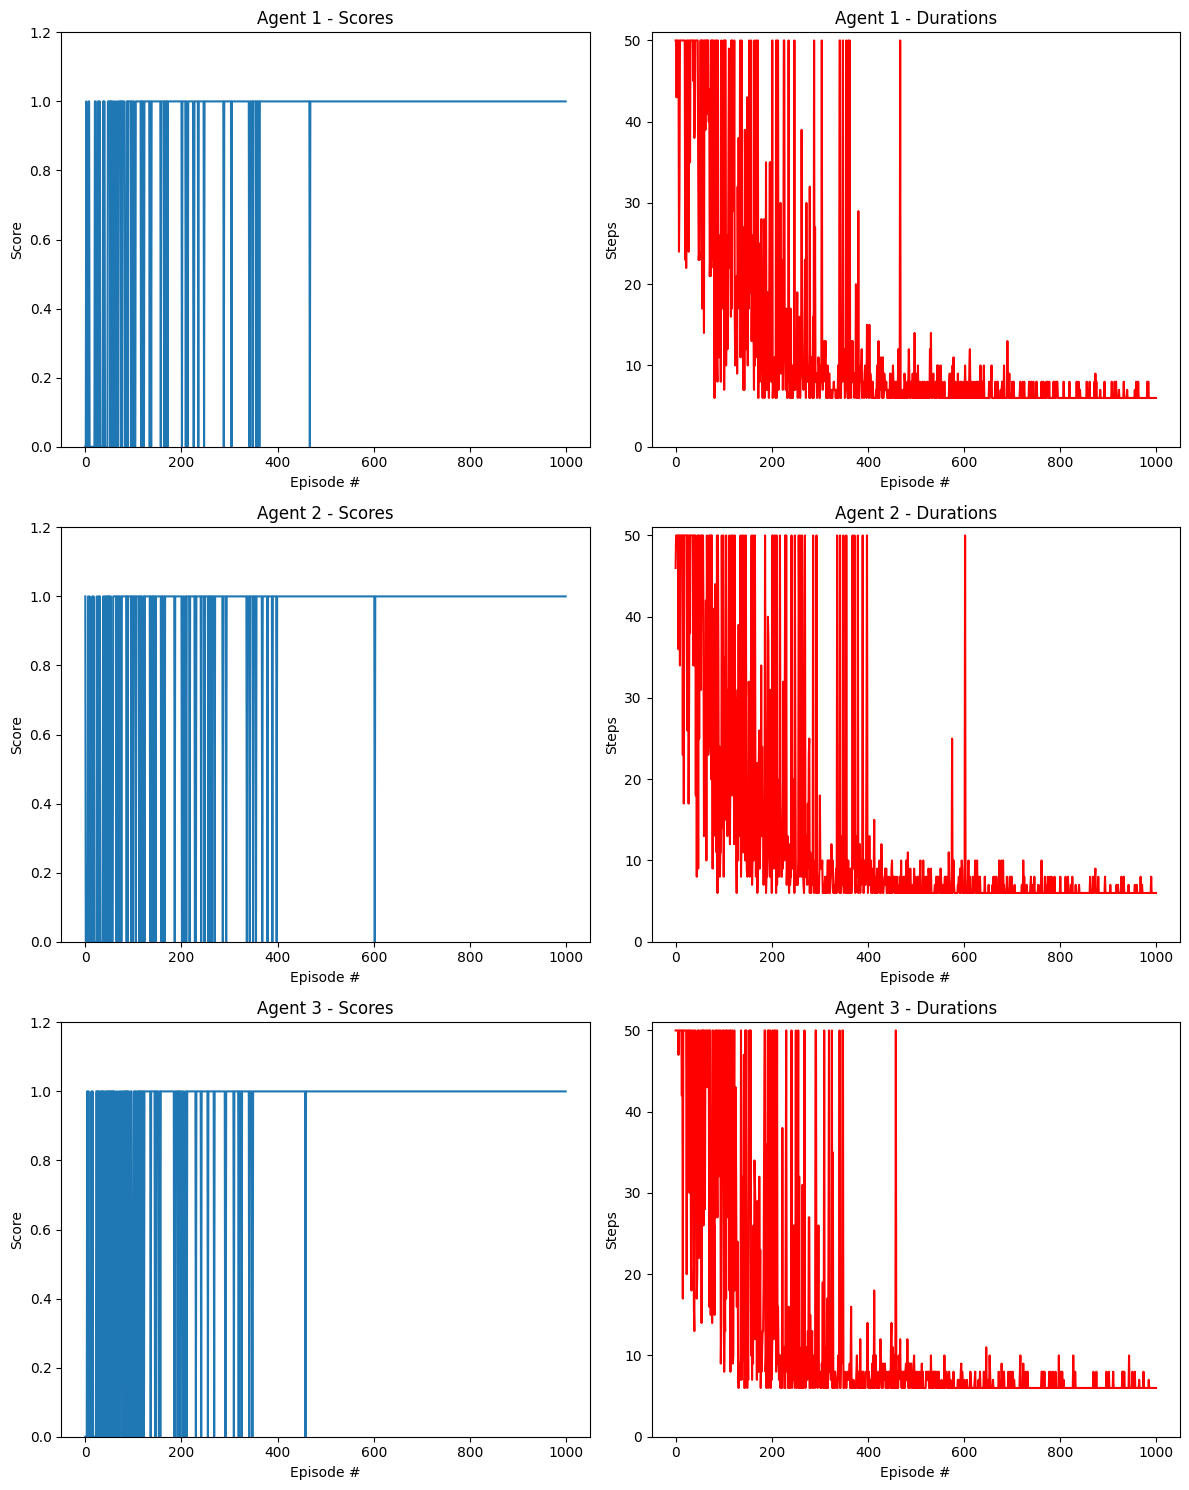

In [22]:
if train and show_stats:
    # Create a figure with subplots for each pair
    fig, axes = plt.subplots(len(agents_arr), 2, figsize=(12, 5*len(agents_arr)))

    for i in range(len(agents_arr)):
        scores = scores_arr[i]  # Access the scores for the current agent
        durations = durations_arr[i]  # Access the durations for the current agent

        # Print information before each pair of subplots
        print("Agent", i+1, "steps stats:", "\tAverage", round(np.mean(durations), 2), "\tStd dev", round(np.std(durations), 2), "\tMedian", round(np.median(durations), 2), "\tBest", np.min(durations))
        ######print("fc1_units:", agents_arr[i].qnetwork_local.fc2.in_features, "\tfc2_units:", agents_arr[i].qnetwork_local.fc2.out_features)
        # Define the axes for the current agent's pair of subplots
        ax_scores = axes[i, 0]
        ax_durations = axes[i, 1]

        # Plot the scores in the first subplot
        ax_scores.plot(np.arange(len(scores)), scores)
        ax_scores.set_ylabel('Score')
        ax_scores.set_xlabel('Episode #')
        ax_scores.set_title(f'Agent {i+1} - Scores')
        
        # Set Y-axis limits for scores between 0 and 1
        ax_scores.set_ylim(0, 1.2)

        # Plot the durations in the second subplot
        ax_durations.plot(np.arange(len(durations)), durations, 'r')
        ax_durations.set_ylabel('Steps')
        ax_durations.set_xlabel('Episode #')
        ax_durations.set_title(f'Agent {i+1} - Durations')

        # Set Y-axis limits for durations 
        ax_durations.set_ylim(0, MAX_STEPS_PER_EPISODE+1)

    plt.tight_layout()
    plt.show()

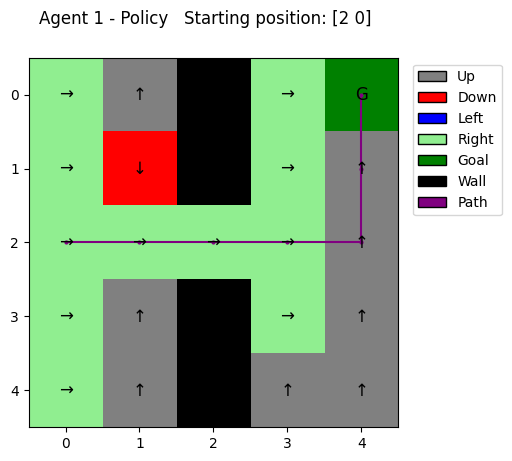

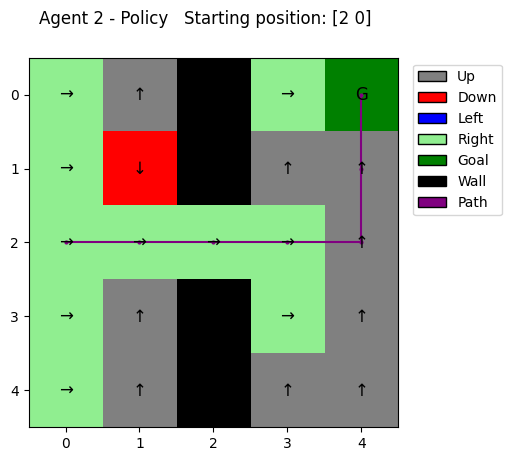

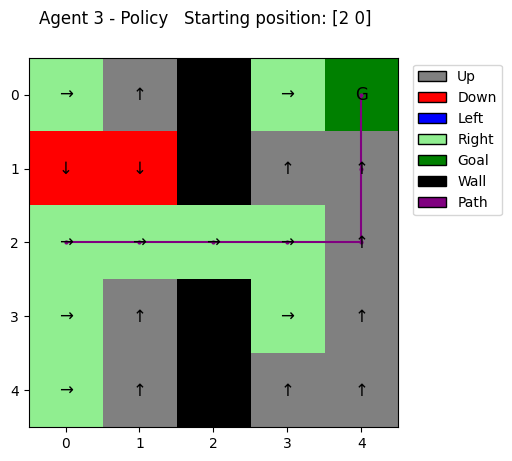

In [23]:
if train:
    for i in range(len(agents_arr)):
        value_grid, policy_grid, string_policy_grid = create_grids(env, Qnet=agents_arr[i].qnetwork_local)
        
        if export_to_JSON:
            if agents_arr.index(agent) < NUM_DQN_AGENTS:
                algorithm = "DQN"
            else:
                algorithm = "DDQN"

            writeJSON(algorithm, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, shape, starting_positions[i], value_grid, policy_grid, string_policy_grid)
        
        if render:
            fig = plot_trajectory(string_policy_grid, starting_positions[i])
            fig.suptitle(f'Agent {i+1} - Policy   Starting position: {starting_positions[i]}')
            plt.show()

In [24]:
#Para cargar todos los modelos que haya creados
"""
    for agent in agents_arr:
        #Aqui tenemos el problema de no conocer sus starting positions originales??
        #env = createNNEnv(shape, randomStart=True)
        if agents_arr.index(agent) < NUM_DQN_AGENTS:
            print("DQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_load = "../data/agent_models/pytorch/DQNagent"+str(agents_arr.index(agent)+1)+".pt"
        else:
            print("DDQN Agent", agents_arr.index(agent)+1,"/",len(agents_arr))
            path_to_load = "../data/agent_models/pytorch/DDQNagent"+str(agents_arr.index(agent)+1-NUM_DQN_AGENTS)+".pt"
        agent.qnetwork_local.load_state_dict(torch.load(path_to_load))
        agent.qnetwork_local.eval()"""

#Demostracion de un agente en el entorno
#Hay que tener cuidado de darle correctamente el mismo tamaño de capas que al modelo que se quiere cargar
"""agent_replay = DDQNAgent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0, fc1_unit=128, fc2_unit=128)
agent_replay.qnetwork_local.load_state_dict(torch.load('../data/agent_models/pytorch/DDQNagent4.pt'))
agent_replay.qnetwork_local.eval()

with open(f"../data/csv/historyDQN.csv", 'a') as f:
    #f.write(f"step,y,x,action,next_y,next_x,reward,done\n")
    for i in range(1):
        obs, _ = env.reset()

        t = 0
        done = False
        while not done:
            action = agent_replay.act(obs)
            prev_state = [obs[0], obs[1], action]
            obs, rew, done, _, _ = env.step(action)

            #f.write(f"{t},{prev_state[0]},{prev_state[1]},{prev_state[2]},{obs[0]},{obs[1]},{rew},{done}\n")
            t += 1
        print("Agente", i+1, "terminado en", t, "pasos")"""

'agent_replay = DDQNAgent(state_size=env.observation_space.shape[0],action_size=env.action_space.n,seed=0, fc1_unit=128, fc2_unit=128)\nagent_replay.qnetwork_local.load_state_dict(torch.load(\'../data/agent_models/pytorch/DDQNagent4.pt\'))\nagent_replay.qnetwork_local.eval()\n\nwith open(f"../data/csv/historyDQN.csv", \'a\') as f:\n    #f.write(f"step,y,x,action,next_y,next_x,reward,done\n")\n    for i in range(1):\n        obs, _ = env.reset()\n\n        t = 0\n        done = False\n        while not done:\n            action = agent_replay.act(obs)\n            prev_state = [obs[0], obs[1], action]\n            obs, rew, done, _, _ = env.step(action)\n\n            #f.write(f"{t},{prev_state[0]},{prev_state[1]},{prev_state[2]},{obs[0]},{obs[1]},{rew},{done}\n")\n            t += 1\n        print("Agente", i+1, "terminado en", t, "pasos")'

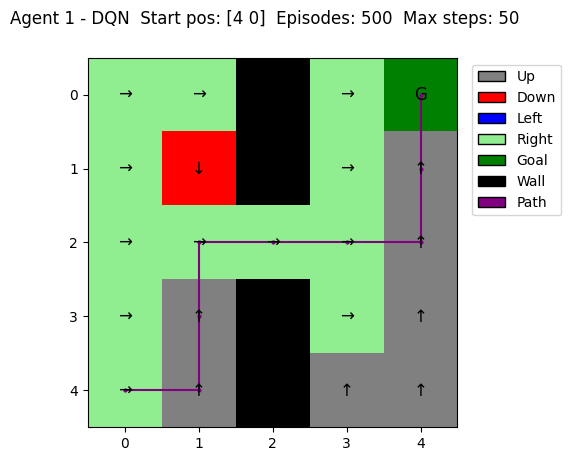

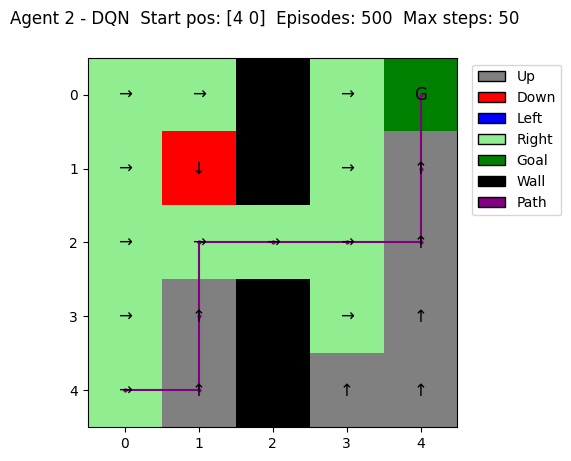

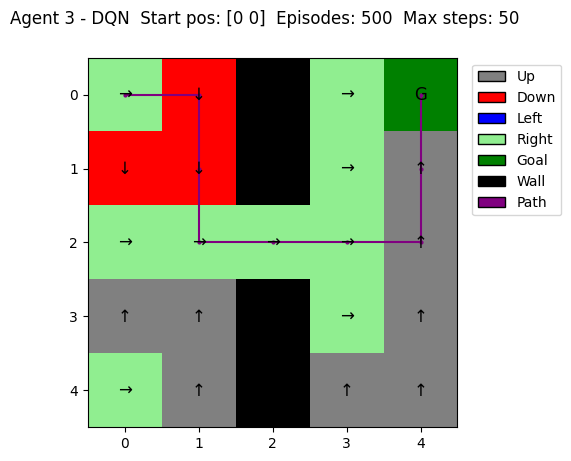

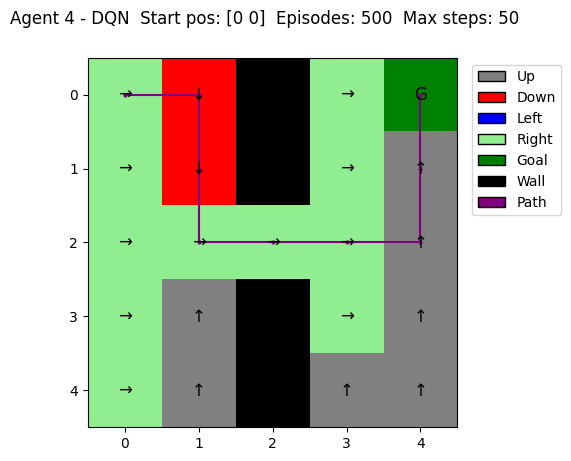

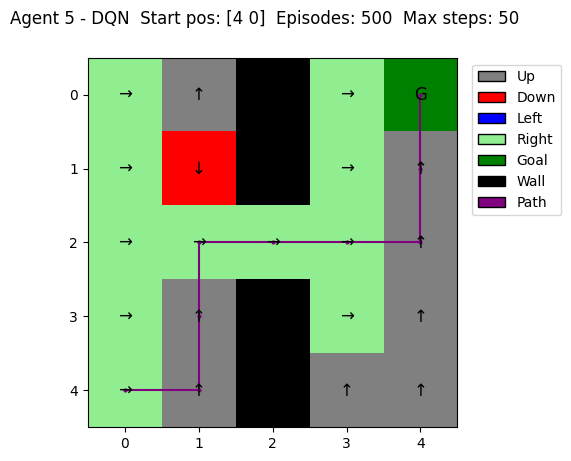

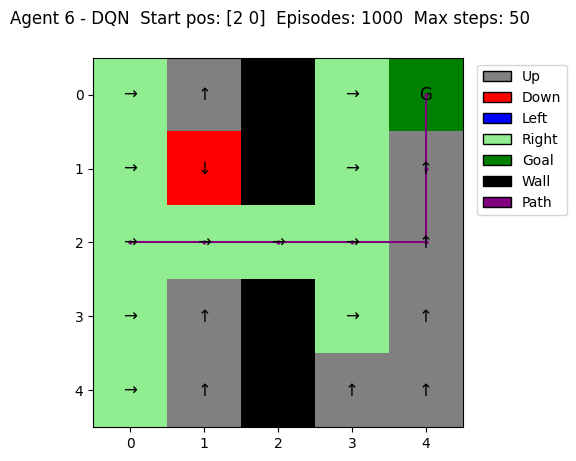

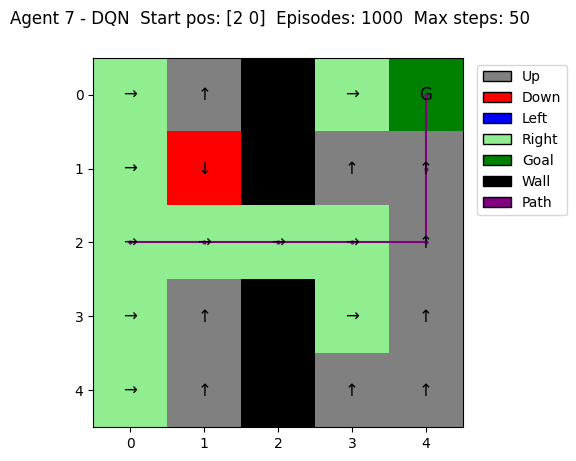

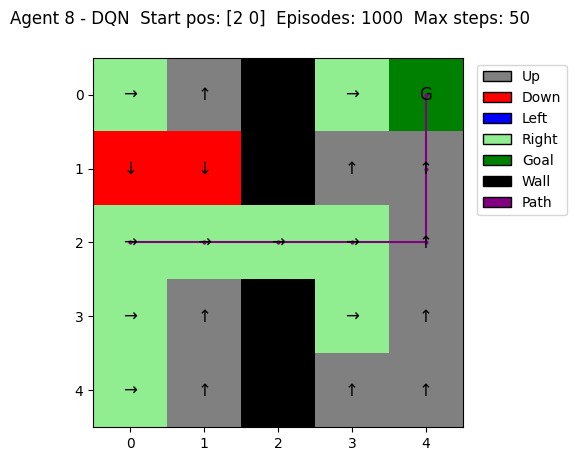

In [25]:
readJSON("DQN", shape)